# HW 8: EE 627

# Part 1:


In [1]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark import SparkContext

sc= SparkContext()

In [2]:
train_data = sc.textFile('trainItem.data')

In [3]:
train_data.take(10)

['199808,248969,90',
 '199808,2663,90',
 '199808,28341,90',
 '199808,42563,90',
 '199808,59092,90',
 '199808,64052,90',
 '199808,69022,90',
 '199808,77710,90',
 '199808,79500,90',
 '199808,82317,90']

In [4]:
train_ratings = train_data.map(lambda l: l.split(','))\
.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))


In [5]:
rank_1=10
numIterations_1 = 10
model_1 = ALS.train(train_ratings, rank_1, numIterations_1)


In [6]:
test_file = sc.textFile("testItem.data")
test_ratings = test_file.map(lambda l: l.split(','))\
.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [7]:
test_data = test_ratings.map(lambda p: (p[0], p[1]))
predictions = model_1.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))

In [20]:
predictions.count

<bound method RDD.count of MapPartitionsRDD[241] at coalesce at NativeMethodAccessorImpl.java:0>

In [8]:
predictions.take(10)

[((204892, 161980), 58.062975858737474),
 ((200223, 21780), -17.526104118462854),
 ((243984, 66368), 55.38720690600057),
 ((201268, 66368), 119.7534460694085),
 ((242273, 66368), 102.38650503226515),
 ((229757, 66368), 72.66718446839342),
 ((200909, 66368), 85.72701059162323),
 ((234509, 66368), 32.18246725062349),
 ((240129, 66368), 66.28820359898558),
 ((243958, 66368), -4.706324924128836)]

In [19]:
predictions.repartition(1)

MapPartitionsRDD[256] at coalesce at NativeMethodAccessorImpl.java:0

In [ ]:
predictions

In [12]:
predictions = predictions.repartition(1)

In [13]:
predictions.saveAsTextFile('test.txt')

In [14]:
predictions.count()

119974

In [15]:
test_data.count()

120000

In [16]:
test_file.count()

120000

In [17]:
test_ratings.count()

120000

In [10]:
test_data.take(10)

[(199810, 208019),
 (199810, 74139),
 (199810, 9903),
 (199810, 242681),
 (199810, 18515),
 (199810, 105760),
 (199812, 276940),
 (199812, 142408),
 (199812, 130023),
 (199812, 29189)]

# Part II:

# 1. 

In [11]:
data = sc.textFile('re_u.data')

In [12]:
data.take(10)

['196,242,3',
 '186,302,3',
 '22,377,1',
 '244,51,2',
 '166,346,1',
 '298,474,4',
 '115,265,2',
 '253,465,5',
 '305,451,3',
 '6,86,3']

In [13]:
data.count()

100000

In [14]:
ratings = data.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [15]:
ranks = [5,7,10,20]
mse_r = [None]*len(ranks)
numIterations = 20

In [16]:
for i in range(len(ranks)):
    rank = ranks[i]
    model = ALS.train(ratings, rank, numIterations)
    
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    mse_r[i] = MSE
    print("Mean Squared Error for rank "+str(rank)+" = "+str(MSE))

Mean Squared Error for rank 5 = 0.6184257066825297
Mean Squared Error for rank 7 = 0.5513882795710545
Mean Squared Error for rank 10 = 0.47161066385520084
Mean Squared Error for rank 20 = 0.2936683391515114


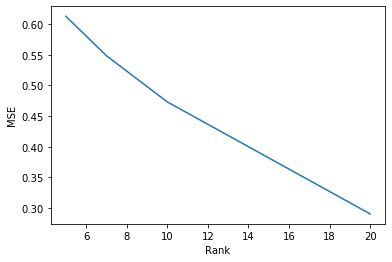

In [26]:
import matplotlib.pyplot as plt
plt.xlabel('Rank')
plt.ylabel('MSE')
plt.plot(ranks,mse_r)

# 2. 

In [27]:
numIters = [2,5,10,20]
mse_n = [None]*len(numIters)
rank = 20
for i in range(len(numIters)):
    numIterations = numIters[i]
    model = ALS.train(ratings, rank, numIterations)
    
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    mse_n[i] = MSE
    print("Mean Squared Error for number of iterations "+str(numIterations)+" = "+str(MSE))

Mean Squared Error for number of iterations 2 = 0.4923116169436986
Mean Squared Error for number of iterations 5 = 0.3421576592939871
Mean Squared Error for number of iterations 10 = 0.3074872445527849
Mean Squared Error for number of iterations 20 = 0.29204901185811016


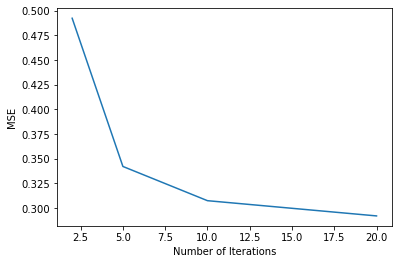

In [29]:
plt.xlabel('Number of Iterations')
plt.ylabel('MSE')
plt.plot(numIters,mse_n)

# 3. 

In [32]:
sizes = [2000,5000,10000,20000,50000,100000]
mse_s = [None]*len(sizes)
numIterations = 20
rank = 20
for i in range(len(sizes)):
    pData = data.take(sizes[i])#this returns a list
    #convert list to RDD
    pData = sc.parallelize(pData)
    ratings = pData.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
    model = ALS.train(ratings, rank, numIterations)
    
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    mse_s[i] = MSE
    print("Mean Squared Error for data size of "+str(sizes[i])+" = "+str(MSE))

Mean Squared Error for data size of 2000 = 9.614212400095245e-05
Mean Squared Error for data size of 5000 = 0.0006578047935117116
Mean Squared Error for data size of 10000 = 0.002906504038477276
Mean Squared Error for data size of 20000 = 0.025380198348017916
Mean Squared Error for data size of 50000 = 0.14982413975151615
Mean Squared Error for data size of 100000 = 0.28988358727033103


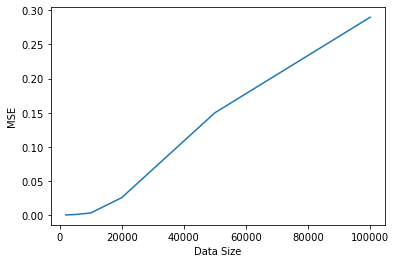

In [34]:
plt.xlabel('Data Size')
plt.ylabel('MSE')
plt.plot(sizes, mse_s)